In [1]:
import re

import numpy as np
import pandas as pd

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from baseline.config import STOP_WORDS

In [2]:
# Load PR Newswire Annotated Dataset
pr_newswire = pd.read_csv("../data/pr-newswire.csv")

In [3]:
def text_cleaning(text: str):
    """Cleans raw text input for Doc2Vec."""
    ps = PorterStemmer()
    
    # Strip punctuation and special chars
    stripped = re.sub(r"[^\w]", " ", text)
    
    # Tokenize and stem words
    tokenized = [
        ps.stem(token.lower()) for token in stripped.split(" ")
        if token.strip() and token.lower() not in STOP_WORDS
    ]
    
    return tokenized

In [4]:
raw_news_stories = pr_newswire["data"]

# Establish data and target for vectorization
stories = list(map(text_cleaning, raw_news_stories))
classifications = list(pr_newswire["target"])

In [5]:
# Build Doc2Vec `TaggedDocument` array
documents = [
    TaggedDocument(story, classifications[idx]) for idx, story in enumerate(stories)
]

In [6]:
# Build Doc2Vec model
d2v = Doc2Vec(vector_size=40, min_count=2, epochs=30)
# Build vocabulary
d2v.build_vocab(documents)

In [7]:
# Train doc2vec
d2v.train(documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [8]:
# Destructure words and tags from TaggedDocument
words = [doc.words for doc in documents]
tags = [doc.tags for doc in documents]

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(words, tags, test_size=0.30)

In [9]:
# Build vectors for training
x_train_vectors = [
    d2v.infer_vector(instance) for instance in x_train
]

# Build LabelEncoder for training
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Encode training lables
y_train_labels = label_encoder.transform(np.asarray(y_train))

In [10]:
# Fit Logistic Regression on infered vectors
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_vectors, y_train_labels)

LogisticRegression(max_iter=1000)

In [11]:
# Build vectors for testing
x_test_vectors = [
    d2v.infer_vector(instance) for instance in x_test
]

In [12]:
# Predictions
y_pred = logreg.predict(x_test_vectors)

In [13]:
# Encode test lables
y_test_labels = label_encoder.transform(y_test)

In [14]:
sum(y_pred == y_test_labels) / len(y_test_labels)

1.0

In [15]:
print(f"Classes: {logreg.classes_}")
print(f"Intercepts: {logreg.intercept_}")
print(f"Coefficient: {logreg.coef_}")

Classes: [0 1 2 3 4]
Intercepts: [-1.73612583  2.48357094 -0.87496209 -2.12554096  2.25305795]
Coefficient: [[-0.02567255  0.02094903  0.03044113 -0.04656357 -0.13843421  0.04845258
  -0.11854524 -0.0546567   0.1843302   0.02178436  0.1269556   0.14296206
   0.05602187  0.23695993 -0.17744135 -0.0940457  -0.07995038 -0.12293863
   0.04267786 -0.1222891   0.0320803   0.02562525  0.00247821 -0.07996972
   0.1940991  -0.10888299 -0.089248   -0.00739349 -0.05942418  0.19752483
   0.08175542  0.06914954  0.10963446  0.12905669  0.00175678  0.03741144
   0.13895523  0.13153616  0.03678726 -0.01918678]
 [ 0.1507471  -0.16325552 -0.12400131 -0.00107521 -0.20047399  0.10421286
  -0.03747996  0.47009845 -0.08302902  0.08101464  0.01342041 -0.10398624
   0.13131551 -0.2411126   0.14408619 -0.08183739  0.13235863 -0.12969431
  -0.00286667  0.27004158  0.08508954 -0.05688978  0.07443646 -0.190826
  -0.28295075 -0.26534334 -0.08442405 -0.27731968  0.04531697  0.01203871
   0.0452675  -0.25995571  0.

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
)

In [17]:
c_matrix = confusion_matrix(y_test_labels, logreg.predict(x_test_vectors))

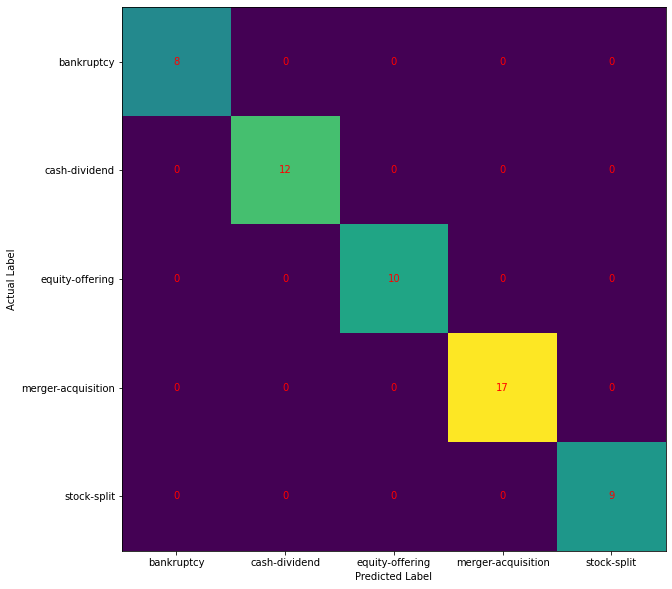

In [18]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(c_matrix)

ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")
labels = tuple(label_encoder.inverse_transform([0, 1, 2, 3, 4]))
ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=labels)
for i in range(len(labels)):  # ref: (https://realpython.com/logistic-regression-python/)
    for j in range(len(labels)):
        ax.text(j, i, c_matrix[i, j], ha='center', va='center', color='red')

In [19]:
# Calculate key metrics
precision = precision_score(y_test_labels, y_pred, average="weighted")
recall = recall_score(y_test_labels, y_pred, average="weighted")
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"Accuracy Score: {accuracy}")

Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
